# Compare Playoff Seeding Outcomes For A Chosen Season
In this notebook I've created a visualization that displays how playoffs standings would be different under the 3-2-1-0 system. 

Currently showing the 2017-2018 NHL season we see that the eventual cup winners, the Washington Capitals would have had a different route to the final facing the Florida Panthers instead of the Columbus Blue Jackets. Would this have changed anything? We can't say for sure. But in that series the Caps went down 0-2 against CBJ but rallied to win the next four. They won that series 4-2 and didn't look back at all continuing on to win Ovechkin's first and only Stanely Cup to date.

In [1]:
# import potentially necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from ipycanvas import Canvas


/Users/brendanlai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Select season of interest
# NOTE: using the 2019-2020 season will be inaccurate due to COVID adding in seeding positions for how the playoff brackets were determined

season_of_interest = "20172018"

In [3]:
df = pd.read_csv(f"standings_dfs/{season_of_interest}_standings.csv")
df = df.rename(columns={'abbreviation': 'abr'})
df['abr'] = df['abr'].astype(str)

### Compute the standings
Computes standings for the two different systems and store in df

In [4]:
def compute_playoffs(row, default_or_3210):
    # row function for computing the playoff spots
    if default_or_3210 == "default":
        return "OUT" if row.division_rank_def > 3 else f"{row.division}{row.division_rank_def}"
    if default_or_3210 == "3210":
        return "OUT" if row.division_rank_3210 > 3 else f"{row.division}{row.division_rank_3210}"

def compute_wildcard(df, def_or_3210):
    # Step 1: Identify teams that are "out" of the playoffs
    out_of_playoffs = df[df[f"ploffs_{def_or_3210}"] == 'OUT']
    playoff_column = f"ploffs_{def_or_3210}"
    points_column = f"points_{def_or_3210}"

    tiebreaker_column = 'num_wins'

    # Check if there are enough teams out of playoffs
    if len(out_of_playoffs) < len(df) / 2:
        return df

    # Step 2-4: Group, sort, and select top 2 teams in each group
    wildcards = (
        out_of_playoffs.groupby(['conference'])
        .apply(lambda group: group.sort_values(by=[points_column, tiebreaker_column], ascending=False).head(2))
        .reset_index(level='conference', drop=True)  # Reset the index to avoid ambiguity
    )

    # Step 5: Update the playoff column
    df.loc[df['team_id'].isin(wildcards.groupby('conference').head(1)['team_id']), playoff_column] = 'WC1'
    df.loc[df['team_id'].isin(wildcards.groupby('conference').tail(1)['team_id']), playoff_column] = 'WC2'

    return df

In [5]:
# Default system first
# Compute divisional playoff entries
df["ploffs_def"] = df.apply(compute_playoffs, default_or_3210="default", axis=1)
df["ploffs_3210"] = df.apply(compute_playoffs, default_or_3210="3210", axis=1)
df = compute_wildcard(df, "def")
df = compute_wildcard(df, "3210")


In [6]:
# Find teams where playoff positions changed
df[df.ploffs_3210 != df.ploffs_def][['teamName', 'ploffs_def', 'ploffs_3210']]

,teamName,ploffs_def,ploffs_3210
3,Panthers,OUT,WC1
18,Devils,WC2,MET3
19,Flyers,MET3,WC2
20,Blue Jackets,WC1,OUT


### Visualize the playoff brackets
Matchups that changed are printed in red

In [7]:
def canvasMatchup(team1, team2, sys, conference, canvas, n):
    # write each matchup into the canvas and return the canvas object
    def isDiffMatchcup(team1, team2):
        return True if team1.ploffs_def.values[0] != team1.ploffs_3210.values[0] or team2.ploffs_def.values[0] != team2.ploffs_3210.values[0] else False

    if isDiffMatchcup(team1, team2):
        canvas.fill_style = "red"
    else:
        canvas.fill_style = "black"


    if conference == "east":
        canvas.fill_text(
            f"{team1['abr'].values[0]} ({team1[f'ploffs_{sys}'].values[0]})  vs  {team2['abr'].values[0]} ({team2[f'ploffs_{sys}'].values[0]})",
            20 if sys == "def" else 350, 
            start_height + 40 * n
        )
    else:
        canvas.fill_text(
            f"{team1['abr'].values[0]} ({team1[f'ploffs_{sys}'].values[0]})  vs  {team2['abr'].values[0]} ({team2[f'ploffs_{sys}'].values[0]})",
            20 if sys == "def" else 350, 
            30 + start_height + 40 * n
        )
    n += 1
    return (canvas, n)

def canvasDivionMatchups(df, div, conference, system, canvas, n):
    # write all matchups for one division into the canvas. n used to manage printing locations
    def compareDivWinners(df, conf, sys):
        # Compare the division winners to get right WC matchup
        if conf == "east":
            atl1 = int(df[df.ploffs_def == "ATL1"][f'points_{sys}'])
            met1 = int(df[df.ploffs_def == "MET1"][f'points_{sys}'])
            return "ATL1" if atl1 > met1 else "MET1"
        else:
            cen1 = int(df[df.ploffs_def == "CEN1"][f'points_{sys}'])
            pac1 = int(df[df.ploffs_def == "PAC1"][f'points_{sys}'])
            return "CEN1" if cen1 > pac1 else "PAC1"

    div_winner = df[df[f"ploffs_{system}"] == f"{div}1"] # Store div winner

    if compareDivWinners(df, conference, system) ==  f"{div}1":
        (canvas, n) = canvasMatchup(div_winner, df[(df[f"ploffs_{system}"] == 'WC2') & (df['conference'] == conference)], system, conference, canvas, n)
    else:
        (canvas, n) = canvasMatchup(div_winner, df[(df[f"ploffs_{system}"] == 'WC1') & (df['conference'] == conference)], system, conference, canvas, n)

    (canvas, n) = canvasMatchup(df[df[f"ploffs_{system}"] == f"{div}2"], df[df[f"ploffs_{system}"] == f"{div}3"], system, conference, canvas, n)
    return (canvas, n)


def printPlayoffBrackets(df, system, canvas):
    n = 1

    # print("Eastern Conference")
    canvas.fill_text("Eastern Conference", left if system == "def" else right, start_height)
    (canvas, n) = canvasDivionMatchups(df, "ATL", "east", system, canvas, n)
    (canvas, n) = canvasDivionMatchups(df, "MET", "east", system, canvas, n)

    # print("Western Conference")
    canvas.fill_style = "black"
    canvas.fill_text("Western Conference", left if system == "def" else right, start_height + 200)
    (canvas, n) = canvasDivionMatchups(df, "CEN", "west", system, canvas, n)
    (canvas, n) = canvasDivionMatchups(df, "PAC", "west", system, canvas, n)

    return canvas

def canvasPlayoffComparison(df, canvas):
    canvas = printPlayoffBrackets(df, "def", canvas)
    return printPlayoffBrackets(df, "3210", canvas)

# instantiate canvas object
canvas = Canvas(width=600, height=500, sync_image_data=True)

start_height = 110
left = 20
right = 350

# print titles
canvas.font = "24px serif"
canvas.fill_text(f"{season_of_interest[:4]} - {season_of_interest[-4:]} NHL Playoff Bracket Comparison", 20, 40)

canvas.font = "18px serif"
canvas.fill_text("Playoff Bracket: Default", left, start_height - 30)
canvas.fill_text("Playoff Bracket: 3-2-1-0", right, start_height - 30)

canvas.font = "15px serif"
canvas.fill_text("VS", 270, 260)

# Print the matchups
canvas = canvasPlayoffComparison(df, canvas)

# Conference boxing
canvas.stroke_rect(left - 5, start_height + 20, left + 185, 155)
canvas.stroke_rect(left - 5, start_height + 210, left + 185, 155)

canvas.stroke_rect(right - 5, start_height + 20, left + 185, 155)
canvas.stroke_rect(right - 5, start_height + 210, left + 185, 155)


### The Result
We see that 3 playoff matchups in this season would have been different. Would this have changed the outcome? No one knows. But with new teams in the playoffs you never know what could have happened...


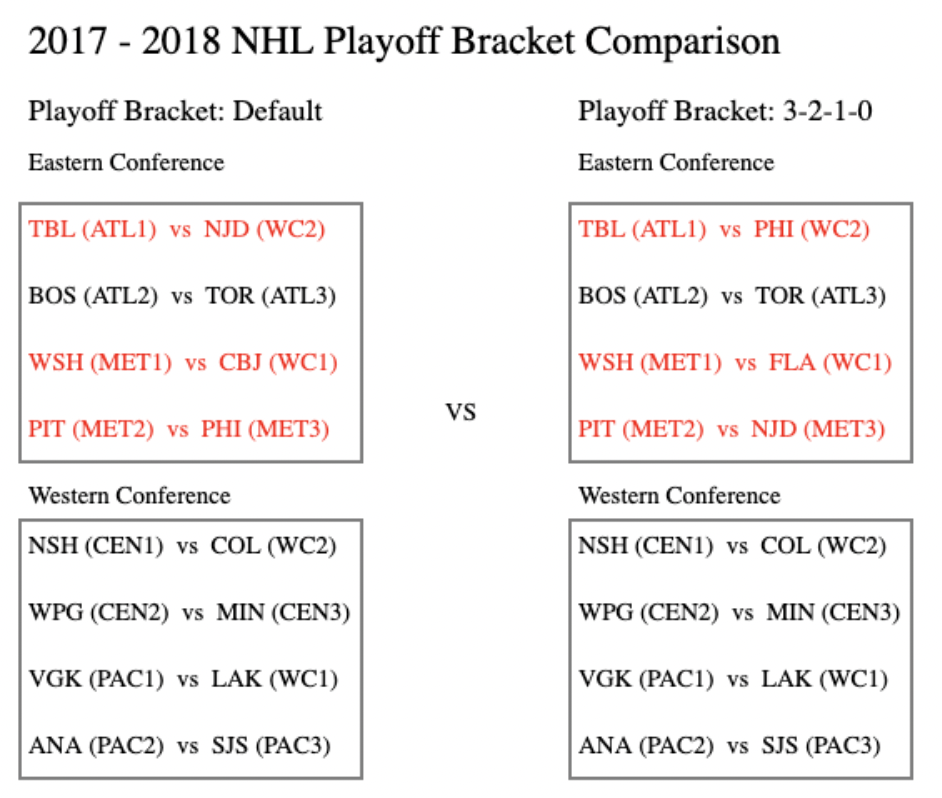